# Time performance foxsisim After reflecivity speed up

Using the **cProfile** python module (suggested by Albert Shi) we were able to test the performance of the program and find out the reason the inclusion of the energy response was taking so much time of the simulation. After some close look of the problem we found the the function responsable for 98% of the procesing time was the *griddata* function in *reflectivity.py*. Wroking with Steven Christe, we changed the function to **inter2d** that not only will work faster but also will give the right reflectivity of the foxsi optics (we found a bug in the old version). <br /> 

<div class="alert alert-success"> 
Today, July 11, 2017, Steven merged the foxsisim repository with the new version of the reflectivity. The idea is to run this notebook as well as *Time-testing-reflectivity-after-speed-up* to check the inprovement in time.
</div>

## Including Energy response for 1000 rays

In [1]:
import cProfile
from foxsisim.module import Module
from foxsisim.detector import Detector
from foxsisim.source import Source
from foxsisim.plotting import plot,scatterHist
import matplotlib.pyplot as plt
import numpy as np

max_energy = 30.0
nrays = 1000

def spectrum(z):
        if (type(z) is not type([1])) and (type(z) is not type(np.array(1))):
            x = np.array([z])
        else:
            x = np.array(z)
        return np.piecewise(x, [x < 0, ((x < max_energy) & (x > 0)), (x >= max_energy)], [0, 1./max_energy, 0])

source_distance = -1e4 ##cm
source = Source(type='point', center=[0, 0, source_distance])
source.loadSpectrum(spectrum)
energies = np.arange(-10, 60, 0.1)

module = Module(radii=[5.151,4.9],focal=200.0)
detector = Detector(width=8,
                    height=8,
                    normal = [0,0,1],
                    center = [0,0,230],
                    reso = [1024,1024])

In [2]:
cProfile.run('rays = source.generateRays(module.targetFront, nrays)')

         52843572 function calls (52843568 primitive calls) in 61.548 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
  1925490   14.070    0.000   54.973    0.000 <ipython-input-1-9ae8287834ed>:12(spectrum)
        1    0.000    0.000   61.548   61.548 <string>:1(<module>)
        3    0.000    0.000    0.000    0.000 <string>:12(__new__)
        1    0.000    0.000    0.000    0.000 <string>:2(<module>)
     8384    0.002    0.000    0.002    0.000 <string>:2(_parse_args)
        1    0.000    0.000    0.000    0.000 <string>:5(_parse_args_rvs)
        1    0.000    0.000    0.001    0.001 _distn_infrastructure.py:1484(__init__)
     8384    0.023    0.000   61.489    0.007 _distn_infrastructure.py:1565(_ppf_to_solve)
     1000    0.010    0.000   61.514    0.062 _distn_infrastructure.py:1568(_ppf_single)
     8384    0.288    0.000   61.467    0.007 _distn_infrastructure.py:1706(cdf)
        3    0.000    0.000    0.000 

In [3]:
cProfile.run('module.passRays(rays, robust=True)')

         1578485 function calls in 2.026 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.026    2.026 <string>:1(<module>)
     1137    0.009    0.000    0.020    0.000 _fitpack_impl.py:990(bisplev)
     1000    0.003    0.000    0.020    0.000 circle.py:44(inRange)
    13942    0.004    0.000    0.004    0.000 fromnumeric.py:1549(shape)
     3137    0.002    0.000    0.007    0.000 fromnumeric.py:504(transpose)
     3137    0.002    0.000    0.005    0.000 fromnumeric.py:55(_wrapfunc)
     2274    0.003    0.000    0.011    0.000 fromnumeric.py:709(sort)
     6971    0.008    0.000    0.010    0.000 getlimits.py:96(__new__)
     1137    0.009    0.000    0.067    0.000 interpolate.py:236(__call__)
     1000    0.001    0.000    0.001    0.000 linalg.py:101(get_linalg_error_extobj)
     2000    0.002    0.000    0.004    0.000 linalg.py:106(_makearray)
    14934    0.007    0.000    0.010   

In [6]:
detector.catchRays(rays)

In [7]:
len(detector.rays)

60

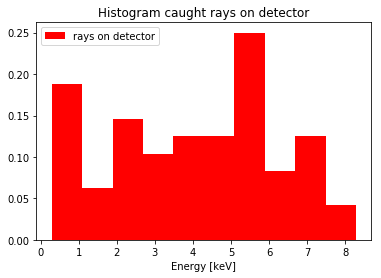

In [8]:
plt.figure()
plt.hist([ray.energy for ray in detector.rays], normed=True, label='rays on detector',color='r')
plt.xlabel('Energy [keV]')
plt.title('Histogram caught rays on detector')
plt.legend()
plt.show()

## No energy response

In [10]:
from foxsisim.module import Module
from foxsisim.detector import Detector
from foxsisim.source import Source
from foxsisim.plotting import scatterHist
from foxsisim.plotting import plot
from foxsisim.util import save_rays
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

In [12]:
module = Module(radii = [5.151,4.9,4.659,4.429,4.21,4.0,3.799], #7Shells
    #module = Module(radii = [5.151,4.9,4.659,4.429,4.21,4.0,3.799,3.59,3.38,3.17], #10Shells
                    seglen=30.0,
                    base=[0,0,0],
                    focal=200,
                    angles=None,
                    conic=False)

detector = Detector(width=10, #27.6 x 27.6 mm values taken from Steven
                    height=10,
                    normal = [0,0,1],
                    center = [0,0,230],
                    reso = [2048,2048]) # Resolution taken from Steven

    #source_distance = -2187.5
source_distance = -1.04e4 #Source distance according to Steve's paper 
offaxis_angle_arcmin = 14.0
source = Source(type='point',
                center=[ source_distance * np.sin(np.deg2rad(offaxis_angle_arcmin/60.0)) , 0.0 , source_distance ],
                color=[1,1,1])
    
photons=100

In [13]:
cProfile.run('rays = source.generateRays(module.targetFront, nrays)')

         1913 function calls in 0.005 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.004    0.004 <string>:1(<module>)
      100    0.000    0.000    0.000    0.000 linalg.py:111(isComplexType)
      100    0.000    0.000    0.001    0.000 linalg.py:2022(norm)
        1    0.000    0.000    0.000    0.000 module.py:242(targetFront)
      100    0.000    0.000    0.000    0.000 numeric.py:463(asarray)
      100    0.000    0.000    0.001    0.000 ray.py:16(__init__)
        1    0.000    0.000    0.000    0.000 segmentp.py:253(targetFront)
        1    0.000    0.000    0.000    0.000 shell.py:75(targetFront)
        1    0.001    0.001    0.004    0.004 source.py:144(generateRays)
        1    0.000    0.000    0.000    0.000 source.py:159(<listcomp>)
        1    0.000    0.000    0.000    0.000 source.py:160(<listcomp>)
        1    0.000    0.000    0.001    0.001 source.py:170(<listcomp

In [14]:
cProfile.run('module.passRays(rays, robust=True)')

         632541 function calls in 0.957 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.957    0.957 <string>:1(<module>)
      100    0.000    0.000    0.002    0.000 circle.py:44(inRange)
     5234    0.002    0.000    0.002    0.000 fromnumeric.py:1549(shape)
      200    0.000    0.000    0.001    0.000 fromnumeric.py:504(transpose)
      200    0.000    0.000    0.000    0.000 fromnumeric.py:55(_wrapfunc)
     2617    0.004    0.000    0.005    0.000 getlimits.py:96(__new__)
      100    0.000    0.000    0.000    0.000 linalg.py:101(get_linalg_error_extobj)
      200    0.000    0.000    0.000    0.000 linalg.py:106(_makearray)
     3365    0.001    0.000    0.002    0.000 linalg.py:111(isComplexType)
      200    0.000    0.000    0.000    0.000 linalg.py:124(_realType)
      100    0.000    0.000    0.001    0.000 linalg.py:139(_commonType)
      100    0.000    0.000    0.000    0.0